In [197]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.impute import MissingIndicator, SimpleImputer, KNNImputer
import scipy.stats as stats

%matplotlib inline

In [198]:
data = pd.read_csv('./vgsales.csv', sep=',', encoding="utf-8")

In [199]:
data.shape
#data.dtypes
#print(9)

(16598, 11)

In [200]:
data.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


In [201]:
data.isnull().sum()
#data = data.drop(data[data["Year"].isnull()].index)
#data = data.drop(data[data["Publisher"].isnull()].index)

Rank              0
Name              0
Platform          0
Year            271
Genre             0
Publisher        58
NA_Sales          0
EU_Sales          0
JP_Sales          0
Other_Sales       0
Global_Sales      0
dtype: int64

In [202]:
# Удаление пропусков
data_drop = data[['Year', 'Publisher']].dropna()
data_drop.shape

(16291, 2)

In [203]:
def plot_hist_diff(old_ds, new_ds, c):
    """
    Разница между распределениями до и после устранения пропусков
    """
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.title.set_text('Поле - ' + str(c))
    old_ds[c].hist(bins=50, ax=ax, density=True, color='blue')
    new_ds[c].hist(bins=50, ax=ax, color='orange', density=True)
    plt.show()

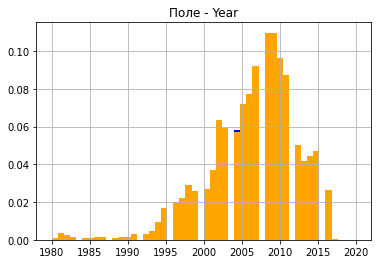

In [204]:
plot_hist_diff(data, data_drop, 'Year')

In [205]:
#почему-то не работает
#plot_hist_diff(data, data_drop, 'Publisher')
data = data.drop(data[data['Publisher'].isnull()].index)
data.shape

(16540, 11)

In [206]:
def impute_column(dataset, column, strategy_param, fill_value_param=None):
    """
    Заполнение пропусков в одном признаке
    """
    temp_data = dataset[[column]].values
    size = temp_data.shape[0]
    
    indicator = MissingIndicator()
    mask_missing_values_only = indicator.fit_transform(temp_data)
    
    imputer = SimpleImputer(strategy=strategy_param, 
                            fill_value=fill_value_param)
    all_data = imputer.fit_transform(temp_data)
    
    missed_data = temp_data[mask_missing_values_only]
    filled_data = all_data[mask_missing_values_only]
    
    return all_data.reshape((size,)), filled_data, missed_data

In [207]:
def research_impute_numeric_column(dataset, num_column, const_value=None):
    strategy_params = ['mean', 'median', 'most_frequent', 'constant']
    strategy_params_names = ['Среднее', 'Медиана', 'Мода']
    strategy_params_names.append('Константа = ' + str(const_value))
    
    original_temp_data = dataset[[num_column]].values
    size = original_temp_data.shape[0]
    original_data = original_temp_data.reshape((size,))
    
    new_df = pd.DataFrame({'Исходные данные':original_data})
       
    for i in range(len(strategy_params)):
        strategy = strategy_params[i]
        col_name = strategy_params_names[i]
        if (strategy!='constant') or (strategy == 'constant' and const_value!=None):
            if strategy == 'constant':
                temp_data, _, _ = impute_column(dataset, num_column, strategy, fill_value_param=const_value)
            else:
                temp_data, _, _ = impute_column(dataset, num_column, strategy)
            new_df[col_name] = temp_data
        
    sns.kdeplot(data=new_df)

In [208]:
#почему-то не рабтоает
#research_impute_numeric_column(data, 'Year')

In [209]:
#заполнение пропуска методом ближайших соседей
year_data = data['Year'].copy().values.reshape(-1, 1)
knnimputer = KNNImputer(
    n_neighbors=5, 
    weights='distance', 
    metric='nan_euclidean', 
    add_indicator=False, 
)
knnimpute_data_imputed_temp = knnimputer.fit_transform(year_data)
knnimpute_data_imputed = pd.DataFrame(knnimpute_data_imputed_temp, columns=['Year'])
knnimpute_data_imputed.head()

,Year
0,2006.0
1,1985.0
2,2008.0
3,2009.0
4,1996.0


In [210]:
# Пропуски заполнены
knnimpute_data_imputed.isnull().sum()

Year    0
dtype: int64

In [211]:
#кодирование категориальных признаков
agg_data = data.groupby("Name").Rank.count().sort_values(ascending=False).reset_index()
agg_data.columns = ["name", "Name_Freq"]
data = pd.merge(data, agg_data, left_on="Name", right_on="name").drop(columns="name")

agg_data = data.groupby("Platform").Rank.count().sort_values(ascending=False).reset_index()
agg_data.columns = ["platform", "Platform_Freq"]
data = pd.merge(data, agg_data, left_on="Platform", right_on="platform").drop(columns="platform")

agg_data = data.groupby("Genre").Rank.count().sort_values(ascending=False).reset_index()
agg_data.columns = ["genre", "Genre_Freq"]
data = pd.merge(data, agg_data, left_on="Genre", right_on="genre").drop(columns="genre")

agg_data = data.groupby("Publisher").Rank.count().sort_values(ascending=False).reset_index()
agg_data.columns = ["publisher", "Publisher_Freq"]
data = pd.merge(data, agg_data, left_on="Publisher", right_on="publisher").drop(columns="publisher")

data = data.sort_values(by=["Rank"])
data.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Name_Freq,Platform_Freq,Genre_Freq,Publisher_Freq
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74,1,1324,2343,703
203,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,2,98,884,703
55,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82,1,1324,1248,703
1,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00,1,1324,2343,703
537,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,1,98,1486,703


In [212]:
def diagnostic_plots(df, variable):
    plt.figure(figsize=(15,6))
    # гистограмма
    plt.subplot(1, 2, 1)
    df[variable].hist(bins=30)
    ## Q-Q plot
    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.show()

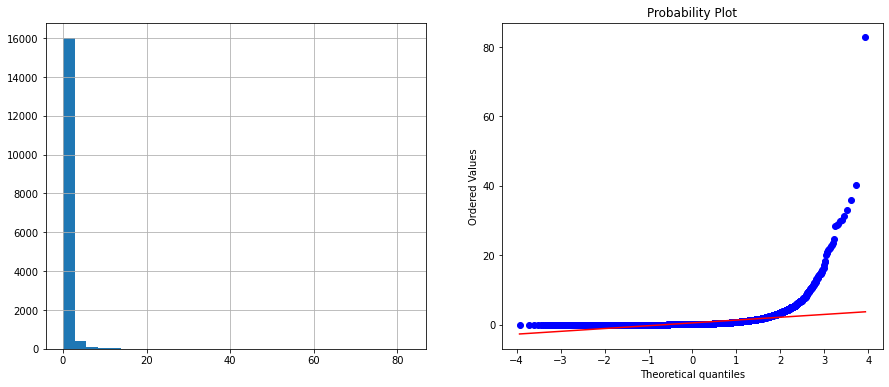

In [215]:
diagnostic_plots(data, 'Global_Sales')

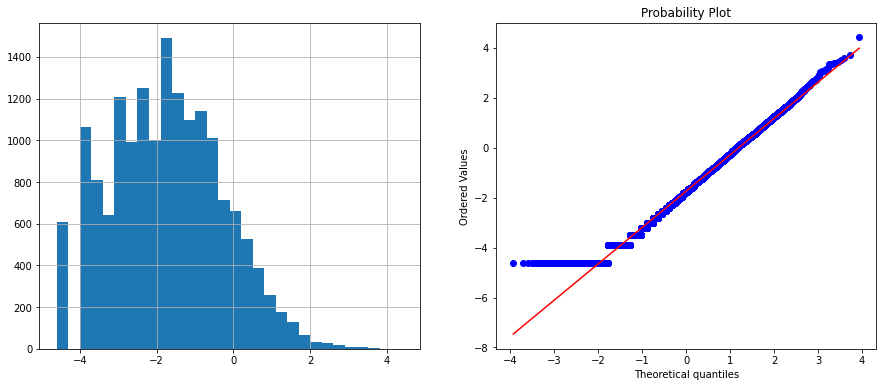

In [216]:
#Логарифм
data['Global_Sales_log'] = np.log(data['Global_Sales'])
diagnostic_plots(data, 'Global_Sales_log')

In [218]:
#Обратное преобразование - очень плохо
#data['Global_Sales_reciprocal'] = 1 / (data['Global_Sales']) 
#diagnostic_plots(data, 'Global_Sales_reciprocal')

In [220]:
#Квадратный корень - почти ничего не дало
#data['Global_Sales_sqrt'] = data['Global_Sales']**(1/2) 
#diagnostic_plots(data, 'Global_Sales_sqrt')

In [226]:
#Возведение в степень - плохо
#data['Global_Sales_exp1'] = data['Global_Sales']**(1/10)
#diagnostic_plots(data, 'Global_Sales_exp1')

Оптимальное значение λ = -0.04832742434731606


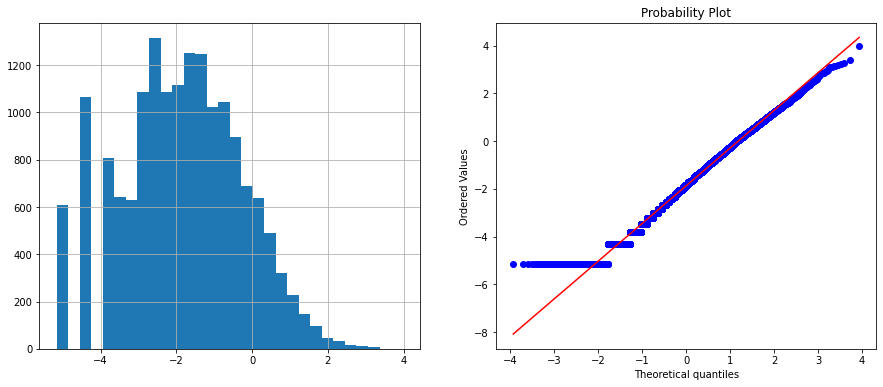

In [228]:
# Преобразование Бокса-Кокса
data['Global_Sales_boxcox'], param = stats.boxcox(data['Global_Sales']) 
print('Оптимальное значение λ = {}'.format(param))
diagnostic_plots(data, 'Global_Sales_boxcox')

In [231]:
# Преобразование Йео-Джонсона - очень плохо
#data['Global_Sales_yeojohnson'], param = stats.yeojohnson(data['Global_Sales']) 
#print('Оптимальное значение λ = {}'.format(param))
#diagnostic_plots(data, 'Global_Sales_yeojohnson')

In [232]:
data.to_csv("./vgsales_ready.csv")